# Simple EDA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

submission = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv')
train_labels = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv')
train = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/test.csv')

In [2]:
train_labels.shape, train.shape, test.shape

((25968, 2), (1558080, 16), (733080, 16))

In [3]:
train['sequence'].unique()

array([    0,     1,     2, ..., 25965, 25966, 25967])

In [4]:
print(f'Number of train sequence: from {train_labels.sequence.min()} to {train_labels.sequence.max()}')
print(f'Number of train sequence: from {train.sequence.min()} to {train.sequence.max()}')
print(f'Number of test sequence: from {test.sequence.min()} to {test.sequence.max()}')
print()

print(f'Number of train subjects: from {train.subject.min()} to {train.subject.max()}')
print(f'Number of test subjects: from {test.subject.min()} to {test.subject.max()}')
print()

print(f'Step(seconds): from {train.step.min()} to {train.step.max()}')
print()

print(f'States: {train_labels.state.unique()}')

Number of train sequence: from 0 to 25967
Number of train sequence: from 0 to 25967
Number of test sequence: from 25968 to 38185

Number of train subjects: from 0 to 671
Number of test subjects: from 672 to 990

Step(seconds): from 0 to 59

States: [0 1]


In [5]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


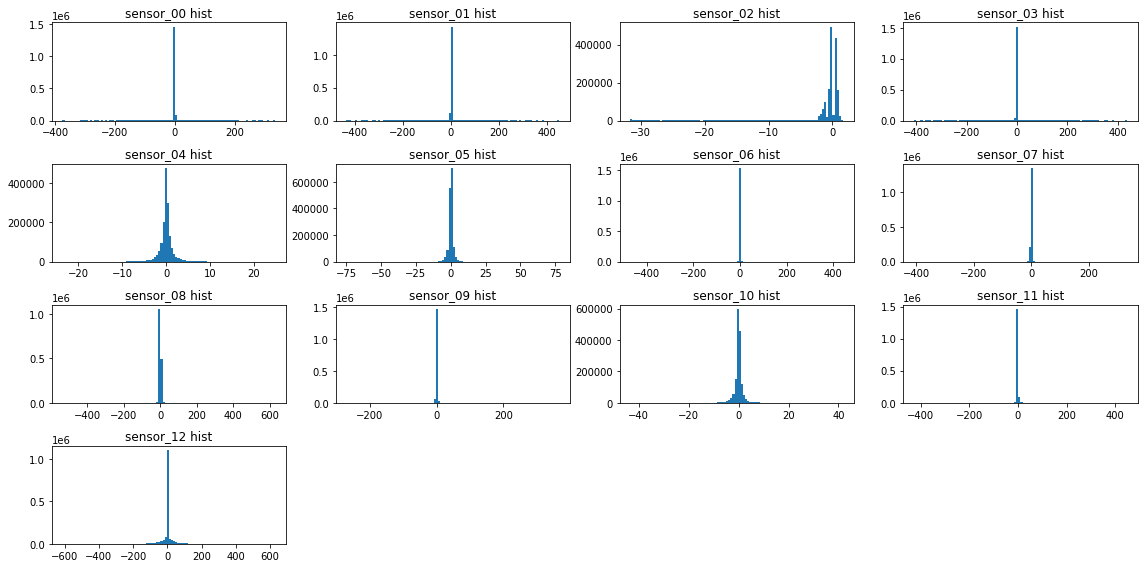

In [6]:
# Check the possible values of the 13 sensors
# 13個のセンサーの取りうる値を調べる
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f'sensor_{sensor:02d}'
    plt.subplot(4, 4, sensor+1)
    plt.hist(train[sensor_name], bins=100)
    plt.title(f'{sensor_name} hist')
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

* As you can see, the histograms show that every sensor has outliers.
* 見てわかる通り、各ヒストグラムには外れ値が存在する
* next -> Exclude outliers(外れ値の除外)

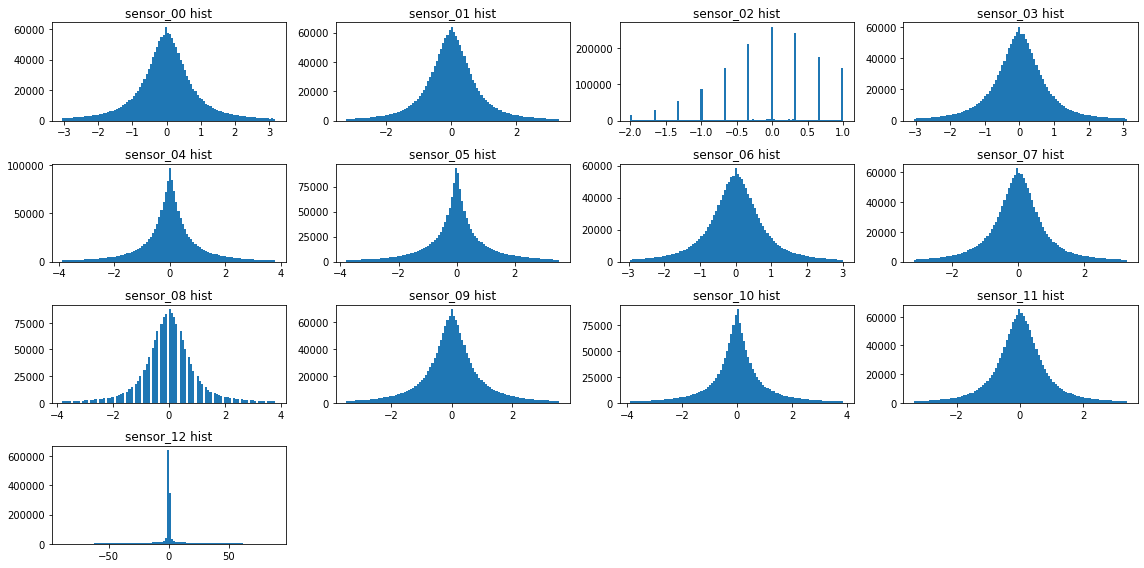

In [7]:
# 外れ値を除外する
# plot the 'inner' part of the histogram after removing 2 % outliers on either side
# 上のヒストグラフから左右2%を除外したグラフをプロットする
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f'sensor_{sensor:02d}'
    plt.subplot(4, 4, sensor+1)
    plt.hist(train[sensor_name], bins=100,
            range=(train[sensor_name].quantile(0.02),
                  train[sensor_name].quantile(0.98)))
    plt.title(f'{sensor_name} hist')
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

In [8]:
print('Count of unique values per sensor:')
for sensor in range(13):
    sensor_name = f'sensor_{sensor:02d}'
    print(f'{sensor_name}: {len(np.unique(train[sensor_name])):6d}')

Count of unique values per sensor:
sensor_00:  25792
sensor_01:  28326
sensor_02:   4771
sensor_03:  26976
sensor_04: 387971
sensor_05:  22839
sensor_06:  25078
sensor_07:  28147
sensor_08:   1924
sensor_09:  30127
sensor_10: 268478
sensor_11:  28932
sensor_12: 303949


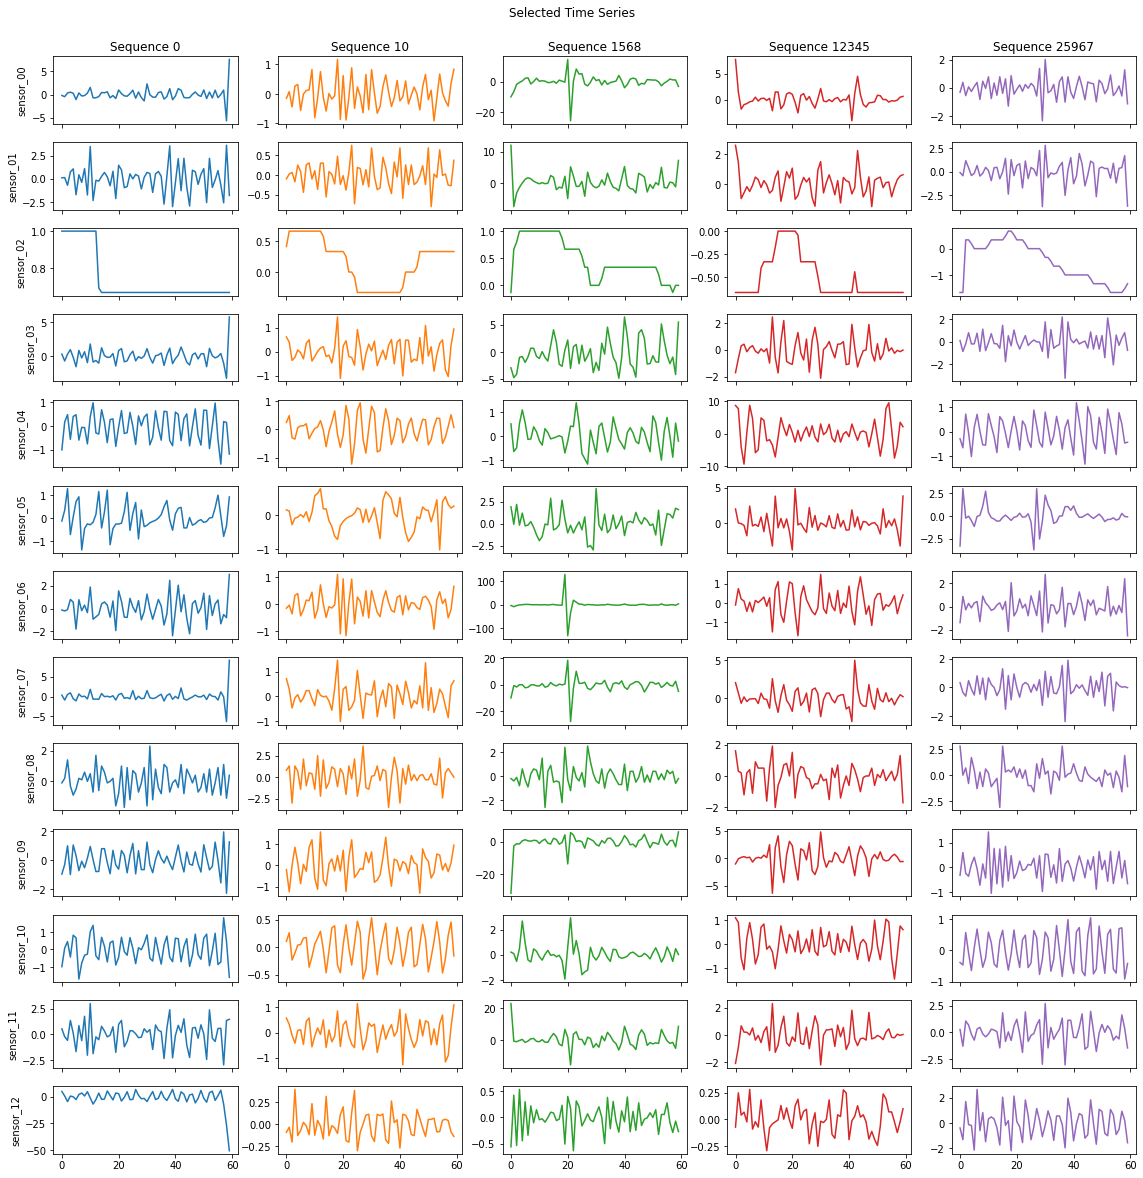

In [9]:
# 20 step(second) interval
# 20秒間隔で各センサーの変動を確認する
# sequenceはrandom値
sequences = [0,10,1568,12345,25967]
figure, axes = plt.subplots(13, len(sequences), sharex=True, figsize=(16, 16))
for i, sequence in enumerate(sequences):
    for sensor in range(13):
        sensor_name = f'sensor_{sensor:02d}'
        plt.subplot(13, len(sequences), sensor * len(sequences) + i + 1)
        plt.plot(range(60), train[train.sequence == sequence][sensor_name],
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i % 10])
        if sensor == 0: plt.title(f'Sequence {sequence}')
        if sequence == sequences[0]: plt.ylabel(sensor_name)
figure.tight_layout(w_pad=0.1)
plt.suptitle('Selected Time Series', y=1.02)
plt.show()

* Characteristic ?
    * sensor02
    * sensor12

# Predict LightGBM

In [10]:
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split,GroupKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
from datetime import datetime

In [11]:
sensor = ['00','01','02','03','04','05','06','07','08','09','10','11','12']

columns = []
for i in sensor:
    columns.append(f'sensor_{i}')
   

def feature_engineer(df):
    df_copy = df.copy()
    for i in sensor:
        mean_value = df.groupby(['sequence', 'subject'])[f'sensor_{i}'].mean()
        mean_value = mean_value.rename(f'sensor_{i}_mean')
        
        std_value  = df.groupby(['sequence','subject'])[f'sensor_{i}'].std()
        std_value  = std_value.rename(f'sensor_{i}_std')
        
        skew_value  = df.groupby(['sequence','subject'])[f'sensor_{i}'].skew()
        skew_value  = skew_value.rename(f'sensor_{i}_skew')
        
        max_value  = df.groupby(['sequence','subject'])[f'sensor_{i}'].max()
        max_value  = max_value.rename(f'sensor_{i}_max')

        min_value  = df.groupby(['sequence','subject'])[f'sensor_{i}'].min()
        min_value  = min_value.rename(f'sensor_{i}_min')
        
        df_copy = df_copy.merge(mean_value, left_on=['sequence', 'subject'], right_index=True)
        df_copy = df_copy.merge(std_value,  left_on=['sequence', 'subject'], right_index=True)
        df_copy = df_copy.merge(skew_value, left_on=['sequence', 'subject'], right_index=True)
        df_copy = df_copy.merge(max_value,  left_on=['sequence', 'subject'], right_index=True)
        df_copy = df_copy.merge(min_value,  left_on=['sequence', 'subject'], right_index=True)
    
    df_copy = df_copy.drop(columns, axis=1)
    df_copy = df_copy[::60]
    return df_copy

In [12]:
df_train = feature_engineer(train)
df_test = feature_engineer(test)

In [13]:
df_train

,sequence,subject,step,sensor_00_mean,sensor_00_std,sensor_00_skew,sensor_00_max,sensor_00_min,sensor_01_mean,sensor_01_std,...,sensor_11_mean,sensor_11_std,sensor_11_skew,sensor_11_max,sensor_11_min,sensor_12_mean,sensor_12_std,sensor_12_skew,sensor_12_max,sensor_12_min
0,0,47,0,0.041744,1.431660,1.488052,7.534003,-5.634467,-0.013025,1.509221,...,0.010391,1.257716,-0.297383,2.989712,-2.972222,-1.286985,8.206880,-4.235184,6.674766,-50.658994
60,1,66,0,-0.069294,1.593907,-0.683454,5.870943,-6.657651,-0.019958,0.949403,...,0.199914,1.774826,1.494927,8.044239,-3.573045,-1.604085,50.291288,-0.222063,144.598039,-160.234442
120,2,66,0,-0.001546,1.147526,0.122688,3.402628,-2.797527,0.025000,0.803884,...,-0.002932,0.611138,-0.309445,1.475309,-1.705761,0.000945,0.361055,0.076284,1.116795,-1.044331
180,3,542,0,0.029869,1.769705,0.306005,4.856260,-3.643740,-0.049177,1.914868,...,-0.026680,1.399494,0.018432,3.593621,-3.837449,-0.003708,0.241708,-0.185013,0.593350,-0.837170
240,4,437,0,0.059132,2.014779,-0.216130,5.455951,-5.331530,0.014916,1.385251,...,-0.099657,2.894626,-0.238575,6.989712,-7.439300,0.000028,0.051600,0.394610,0.135976,-0.098465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557780,25963,558,0,0.100773,1.547826,0.069687,3.974498,-3.738022,0.007073,1.985067,...,-0.046674,3.266255,0.784586,11.134774,-6.088477,-0.008582,0.096523,0.387713,0.297954,-0.262575
1557840,25964,297,0,0.017182,1.054727,-1.690229,2.927357,-5.220247,0.004814,0.962603,...,0.006224,0.829925,0.263871,2.559671,-2.101852,-0.073288,18.435077,0.008597,40.998295,-37.633845
1557900,25965,129,0,-0.006466,1.227428,-0.142272,2.818393,-3.422720,0.004447,1.317566,...,0.004544,1.310547,0.374499,2.876543,-2.271605,0.020439,1.014761,-0.248692,2.394714,-2.837170
1557960,25966,170,0,-0.040417,0.885836,-0.259944,1.710974,-2.069552,0.003256,5.877563,...,-0.039866,5.289579,-2.991772,14.172840,-30.849794,-2.050611,20.422100,-0.230789,48.826939,-56.968031


In [14]:
df_test

,sequence,subject,step,sensor_00_mean,sensor_00_std,sensor_00_skew,sensor_00_max,sensor_00_min,sensor_01_mean,sensor_01_std,...,sensor_11_mean,sensor_11_std,sensor_11_skew,sensor_11_max,sensor_11_min,sensor_12_mean,sensor_12_std,sensor_12_skew,sensor_12_max,sensor_12_min
0,25968,684,0,-0.002602,1.091741,-0.927921,3.146832,-4.950541,-0.036432,4.499484,...,0.025977,2.892104,-0.587927,10.980453,-11.584362,-0.000945,0.369897,-0.145905,0.716539,-0.809889
60,25969,935,0,0.028516,1.450040,1.644888,5.816074,-3.675425,0.002276,0.775379,...,-0.001423,0.925089,0.122746,3.163580,-2.414609,0.024290,0.659728,-0.075055,1.224638,-1.237852
120,25970,924,0,0.057664,5.083618,-0.634247,12.306028,-15.005410,-0.021796,2.903657,...,-0.046451,2.846617,0.238176,9.640947,-7.376543,0.071284,19.027800,0.205394,36.157289,-36.565644
180,25971,769,0,-0.004791,0.914917,0.218435,2.876352,-2.465997,0.014863,0.950923,...,-0.001886,0.545613,0.691860,1.671811,-1.484568,0.021114,0.889882,-0.181651,1.488917,-2.574595
240,25972,764,0,-0.001443,2.783685,3.383219,17.295209,-9.974498,-0.025350,23.942241,...,-0.015912,13.526715,3.737440,86.235597,-42.858025,12.399581,153.174703,-0.313355,323.667093,-328.497869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732780,38181,980,0,-0.047746,1.105589,1.537281,5.135240,-3.358578,-0.029289,0.865220,...,-0.019187,1.013227,-0.498348,1.830247,-3.160494,-0.071398,89.874298,0.054471,174.751492,-152.523444
732840,38182,915,0,-0.016473,4.500443,2.817622,26.738794,-13.154560,-0.023547,7.808577,...,-0.068861,23.866845,-1.012753,102.877572,-124.448560,0.017271,0.415513,2.295752,2.039216,-0.813725
732900,38183,872,0,-0.005500,2.082974,1.434987,8.312983,-4.977589,0.039653,0.833157,...,0.046931,0.978098,0.028720,2.804527,-2.248971,0.009541,0.628490,0.122701,1.105286,-1.072890
732960,38184,835,0,-0.032573,3.185580,-0.172654,6.951314,-8.993818,-0.022584,3.064000,...,0.018210,2.718383,-0.122553,6.703704,-6.011317,-0.001549,0.433795,0.294389,0.819693,-0.636402


In [15]:
X_train = df_train.drop(["sequence", "subject"], axis=1).reset_index(drop=True)
y_train = train_labels.drop(["sequence"], axis=1)
X_test  = df_test.drop(["sequence", "subject"], axis=1).reset_index(drop=True)

In [16]:
X_train

,step,sensor_00_mean,sensor_00_std,sensor_00_skew,sensor_00_max,sensor_00_min,sensor_01_mean,sensor_01_std,sensor_01_skew,sensor_01_max,...,sensor_11_mean,sensor_11_std,sensor_11_skew,sensor_11_max,sensor_11_min,sensor_12_mean,sensor_12_std,sensor_12_skew,sensor_12_max,sensor_12_min
0,0,0.041744,1.431660,1.488052,7.534003,-5.634467,-0.013025,1.509221,0.149115,3.623950,...,0.010391,1.257716,-0.297383,2.989712,-2.972222,-1.286985,8.206880,-4.235184,6.674766,-50.658994
1,0,-0.069294,1.593907,-0.683454,5.870943,-6.657651,-0.019958,0.949403,-0.182128,2.525210,...,0.199914,1.774826,1.494927,8.044239,-3.573045,-1.604085,50.291288,-0.222063,144.598039,-160.234442
2,0,-0.001546,1.147526,0.122688,3.402628,-2.797527,0.025000,0.803884,0.228538,2.321429,...,-0.002932,0.611138,-0.309445,1.475309,-1.705761,0.000945,0.361055,0.076284,1.116795,-1.044331
3,0,0.029869,1.769705,0.306005,4.856260,-3.643740,-0.049177,1.914868,-0.129397,6.722689,...,-0.026680,1.399494,0.018432,3.593621,-3.837449,-0.003708,0.241708,-0.185013,0.593350,-0.837170
4,0,0.059132,2.014779,-0.216130,5.455951,-5.331530,0.014916,1.385251,-1.183571,3.532563,...,-0.099657,2.894626,-0.238575,6.989712,-7.439300,0.000028,0.051600,0.394610,0.135976,-0.098465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,0,0.100773,1.547826,0.069687,3.974498,-3.738022,0.007073,1.985067,-0.144970,4.161765,...,-0.046674,3.266255,0.784586,11.134774,-6.088477,-0.008582,0.096523,0.387713,0.297954,-0.262575
25964,0,0.017182,1.054727,-1.690229,2.927357,-5.220247,0.004814,0.962603,-0.133026,2.758403,...,0.006224,0.829925,0.263871,2.559671,-2.101852,-0.073288,18.435077,0.008597,40.998295,-37.633845
25965,0,-0.006466,1.227428,-0.142272,2.818393,-3.422720,0.004447,1.317566,0.207825,3.826681,...,0.004544,1.310547,0.374499,2.876543,-2.271605,0.020439,1.014761,-0.248692,2.394714,-2.837170
25966,0,-0.040417,0.885836,-0.259944,1.710974,-2.069552,0.003256,5.877563,-2.727021,19.019958,...,-0.039866,5.289579,-2.991772,14.172840,-30.849794,-2.050611,20.422100,-0.230789,48.826939,-56.968031


In [17]:
y_train

,state
0,0
1,1
2,1
3,1
4,1
...,...
25963,1
25964,0
25965,1
25966,1


In [18]:
X_test

,step,sensor_00_mean,sensor_00_std,sensor_00_skew,sensor_00_max,sensor_00_min,sensor_01_mean,sensor_01_std,sensor_01_skew,sensor_01_max,...,sensor_11_mean,sensor_11_std,sensor_11_skew,sensor_11_max,sensor_11_min,sensor_12_mean,sensor_12_std,sensor_12_skew,sensor_12_max,sensor_12_min
0,0,-0.002602,1.091741,-0.927921,3.146832,-4.950541,-0.036432,4.499484,-0.758753,19.639706,...,0.025977,2.892104,-0.587927,10.980453,-11.584362,-0.000945,0.369897,-0.145905,0.716539,-0.809889
1,0,0.028516,1.450040,1.644888,5.816074,-3.675425,0.002276,0.775379,-0.163115,1.763655,...,-0.001423,0.925089,0.122746,3.163580,-2.414609,0.024290,0.659728,-0.075055,1.224638,-1.237852
2,0,0.057664,5.083618,-0.634247,12.306028,-15.005410,-0.021796,2.903657,-0.105087,5.900210,...,-0.046451,2.846617,0.238176,9.640947,-7.376543,0.071284,19.027800,0.205394,36.157289,-36.565644
3,0,-0.004791,0.914917,0.218435,2.876352,-2.465997,0.014863,0.950923,-0.122199,2.435924,...,-0.001886,0.545613,0.691860,1.671811,-1.484568,0.021114,0.889882,-0.181651,1.488917,-2.574595
4,0,-0.001443,2.783685,3.383219,17.295209,-9.974498,-0.025350,23.942241,-1.255583,115.925420,...,-0.015912,13.526715,3.737440,86.235597,-42.858025,12.399581,153.174703,-0.313355,323.667093,-328.497869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12213,0,-0.047746,1.105589,1.537281,5.135240,-3.358578,-0.029289,0.865220,-0.371598,2.111345,...,-0.019187,1.013227,-0.498348,1.830247,-3.160494,-0.071398,89.874298,0.054471,174.751492,-152.523444
12214,0,-0.016473,4.500443,2.817622,26.738794,-13.154560,-0.023547,7.808577,-1.369849,32.420168,...,-0.068861,23.866845,-1.012753,102.877572,-124.448560,0.017271,0.415513,2.295752,2.039216,-0.813725
12215,0,-0.005500,2.082974,1.434987,8.312983,-4.977589,0.039653,0.833157,-0.774067,1.739496,...,0.046931,0.978098,0.028720,2.804527,-2.248971,0.009541,0.628490,0.122701,1.105286,-1.072890
12216,0,-0.032573,3.185580,-0.172654,6.951314,-8.993818,-0.022584,3.064000,-0.348204,7.495798,...,0.018210,2.718383,-0.122553,6.703704,-6.011317,-0.001549,0.433795,0.294389,0.819693,-0.636402


## Model

In [19]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 8,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.8, 
        'metric': 'auc'
    }

kf = KFold(n_splits = 5, shuffle = True, random_state = 70)
models = []
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    print(f'--------fold:{fold+1}--------')
    fold+=1
    tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    data_train = lgb.Dataset(tr_x, tr_y)
    data_val = lgb.Dataset(va_x, va_y)
    
    
    lgb_results = {}   
    model = lgb.train(
        params = params,
        train_set = data_train,
        valid_sets = [data_val ,data_train],
        valid_names=['eval', 'train'],
        num_boost_round = 1000,
      #  valid_sets = watchlist,
        early_stopping_rounds=50,
        evals_result=lgb_results,
        verbose_eval=100
    )
    models.append(model)

--------fold:1--------
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10434, number of negative: 10340
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16494
[LightGBM] [Info] Number of data points in the train set: 20774, number of used features: 65


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and w

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502262 -> initscore=0.009050
[LightGBM] [Info] Start training from score 0.009050
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.863209	eval's auc: 0.827647
[200]	train's auc: 0.884303	eval's auc: 0.843403
[300]	train's auc: 0.901418	eval's auc: 0.855538
[400]	train's auc: 0.915589	eval's auc: 0.864845
[500]	train's auc: 0.927242	eval's auc: 0.872377
[600]	train's auc: 0.936368	eval's auc: 0.877705
[700]	train's auc: 0.943936	eval's auc: 0.881864
[800]	train's auc: 0.950423	eval's auc: 0.884946
[900]	train's auc: 0.95611	eval's auc: 0.887195
[1000]	train's auc: 0.961092	eval's auc: 0.8893
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.961092	eval's auc: 0.8893
--------fold:2--------
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly s

## Predict

In [20]:
prediction = np.zeros(X_test.shape[0])
for i, model in enumerate(models):
    pred = model.predict(X_test)
    prediction += pred
prediction = prediction/len(models)

In [21]:
prediction

array([0.88624313, 0.90891331, 0.08445119, ..., 0.70736673, 0.06994645,
       0.15352541])

In [22]:
submission['state'] = prediction
submission.to_csv('submission.csv', index=False)